In [148]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


In [165]:
def createPoints(num_points=10, sigma=0.2):
    points = np.zeros((3, num_points), dtype=float)
    cmap_idx = np.linspace(0,1,num_points, dtype=float)
    cov = np.eye(3) * sigma**2
    # Calculate first point

    points[:,0] = np.random.rand(3,1)[:,0]
    for j in range(num_points-1):
        points[:,j+1] = np.random.multivariate_normal(points[:,j], cov)
    
    return points, cmap_idx



def calculateMoments(support_points, dt):
        
    x = support_points[0,:]
    y = support_points[1,:]
    z = support_points[2,:]

    n = support_points.shape[1]

    A = np.eye(n-2, k=0) * 4 + np.eye(n-2, k=1) + np.eye(n-2, k=-1)

    bx = 6/(dt**2) * (x[2:] - 2 * x[1:(n-1)] + x[0:(n-2)])
    by = 6/(dt**2) * (y[2:] - 2 * y[1:(n-1)] + y[0:(n-2)])
    bz = 6/(dt**2) * (z[2:] - 2 * z[1:(n-1)] + z[0:(n-2)])

    m = np.zeros((3,n))
    m[0,1:(n-1)] = np.linalg.solve(A, bx)
    m[1,1:(n-1)] = np.linalg.solve(A, by)
    m[2,1:(n-1)] = np.linalg.solve(A, bz)
    
    return m



def calculatePath(support_points, moments, dt, sampling_frequency):
    interval_points = int(dt * sampling_frequency)
    
    n = support_points.shape[1]


    t = np.linspace(0, dt * (n-1), interval_points*(n-1)+1)
    p = np.zeros((3, t.shape[0]))

    
    for j in range(n-1):
        tmp1 = t[j*interval_points:(j+1)*interval_points +1] -  np.ones((1,interval_points+1)) * (dt * j)            # x - x_n
        tmp2 = np.ones((1,interval_points+1)) * (dt * (j+1)) - t[j*interval_points:(j+1)*interval_points+1]         # x_n+1 - x

        for i in range(3):
            factor1 = support_points[i,j+1] - dt**2/6 * moments[i,j+1]
            factor2 = support_points[i,j] - dt**2/6 * moments[i,j]

            p[i, j*interval_points: (j+1)*interval_points+1] = 1/(6*dt) * np.power(tmp1, 3) * moments[i,j+1] +  1/(6*dt) * np.power(tmp2, 3) * moments[i,j] + tmp1/dt * factor1 + tmp2/dt * factor2
    
    return t,p

def calculateVelocities(support_points, moments, dt, sampling_frequency):
    interval_points = int(dt * sampling_frequency)
    
    n = support_points.shape[1]


    t = np.linspace(0, dt * (n-1), interval_points*(n-1)+1)
    v = np.zeros((3, t.shape[0]))

    for j in range(n-1):
        tmp1 = t[j*interval_points:(j+1)*interval_points +1] -  np.ones((1,interval_points+1)) * (dt * j)            # x - x_n
        tmp2 = np.ones((1,interval_points+1)) * (dt * (j+1)) - t[j*interval_points:(j+1)*interval_points+1]         # x_n+1 - x

        for i in range(3):
            factor1 = support_points[i,j+1] - dt**2/6 * moments[i,j+1]
            factor2 = support_points[i,j] - dt**2/6 * moments[i,j]

            v[i, j*interval_points: (j+1)*interval_points+1] = 1/(2*dt) * np.power(tmp1, 2) * moments[i,j+1] -  1/(2*dt) * np.power(tmp2, 2) * moments[i,j] + 1/dt * factor1 - 1/dt * factor2
    
    return t,v

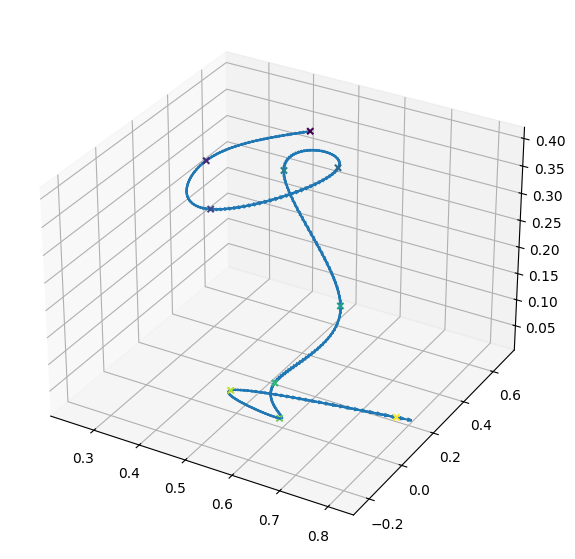

In [166]:
num_points = 10

val = np.random.rand(3,num_points)

fig = plt.figure(figsize=(8, 7))
ax = plt.axes(projection="3d")

p, idx = createPoints()


ax.scatter3D(p[0,:], p[1,:], zs=p[2,:], cmap=matplotlib.colormaps.get_cmap('viridis'), c = idx, s=20, marker='x', alpha=1)

ax.set_xlim([np.min(p,axis=1)[0],np.max(p,axis=1)[0]])
ax.set_ylim([np.min(p,axis=1)[1],np.max(p,axis=1)[1]])
ax.set_zlim([np.min(p,axis=1)[2],np.max(p,axis=1)[2]])


m = calculateMoments(p,1)
t, points = calculatePath(p, m, 1, 30)
t, velocities = calculateVelocities(p, m, 1, 30)

abs_vel = np.linalg.norm(velocities, axis=0)
max_vel = np.max(abs_vel)
ax.plot3D(points[0,:], points[1,:], points[2,:], '-')
for i in range(t.shape[0]):
    ax.quiver(points[0,i], points[1,i], points[2,i], velocities[0,i]/max_vel * 0.05, velocities[1,i]/max_vel * 0.05, velocities[2,i]/max_vel *0.05)

plt.show()